In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/Shareddrives/행복 범주 화이팅!

/content/drive/Shareddrives/행복 범주 화이팅!


In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/review_checked_final.csv')


### 태그 원핫인코딩

In [ ]:
tag = pd.read_csv('data/final_tag.csv')
tag.drop(['Unnamed: 0','story_tag'],axis=1,inplace=True)

In [ ]:
tag.loc[1,'tag'].replace(' ','')

'요괴및괴물,이능력,열혈,교복'

In [ ]:
all_genre=[]

for i in range(0,len(tag['tag'])):
  try:
    tag.loc[i,'tag'] = tag.loc[i,'tag'].replace(' ','')
    all_genre.extend(tag.loc[i,'tag'].split(','))
  except:
    pass

In [ ]:
genre = pd.unique(all_genre)
genre

array(['요괴및괴물', '열혈', '이능력', '교복', '귀신', '발랄가볍', '주체적여성', '히어로', '먼치킨',
       '귀여움', '선생님', '악마또는천사', '마왕', '미소년', '미소녀', '전사', '군인', '연예인',
       '오타쿠', '탐정', '카리스마', '아싸', '외계인', '기억상실', '뱀파이어', '동물', '쌍둥이',
       '헌터', '아이돌', '싸우는미소녀', '로봇', '좀비', '마법소녀', '도둑', '경찰', '공룡', '자동차'],
      dtype=object)

In [ ]:
zm = np.zeros((len(tag),len(genre)))
dum = pd.DataFrame(zm,columns = genre)

In [ ]:
for i,gen in enumerate(tag['tag']):
  try:
    indices = dum.columns.get_indexer(gen.split(','))
    dum.iloc[i,indices] = 1
  except:
    pass

In [ ]:
final_dum = pd.concat([tag['제목'],dum],axis=1)
final_dum.to_csv('주인공태그원핫.csv')

### 1. okt

In [ ]:
!pip install konlpy
import konlpy

In [ ]:
from konlpy.tag import Okt
okt = Okt()

# 명사
def tokenize(doc):
    wordlist = []
    for word, tag in okt.pos(doc, norm =True, stem=True):
        if tag in ['Verb','Adjective','Adverb','Noun']:
            wordlist.append(word)
    return(wordlist)

In [ ]:
tokenize('중병 전개는 성우분 연기 덕에 생각보다 재미있게 봤는데 지루한 파트 역시 그냥 건너뛰기로 슉슉 넘기면 재미있게 볼 수 있었던 것 같은')

In [ ]:
token_data=[]

for value in data['review_checked']:
    tok = tokenize(value)
    token_data.append(tok)

In [ ]:
token_data_okt = token_data

In [ ]:
token_data_okt

In [ ]:
token_string = []

for i in token_data:
  token_string.append(' '.join(i))

In [ ]:
drop_corpus = []

for index in range(len(token_string)):
    corpus = token_string[index]
    if len(set(corpus.split())) < 3:   # 같은 단어 1-2개만 반복되는 corpus도 지우기 위해 set()을 사용
        drop_corpus.append(corpus)
    
for corpus in drop_corpus:
    token_string.remove(corpus)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
count_vectorizer = CountVectorizer(max_df=0.1, max_features=1000, min_df=2, ngram_range=(1,2),stop_words=['멤버십','보고','그냥','이제','제발','라프텔'])
    # 2개의 문서 미만으로 등장하는 단어는 제외, 전체의 10% 이상으로 자주 등장하는 단어는 제외
    # bigram도 포함

feat_vect = count_vectorizer.fit_transform(token_string)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (151974, 1000)


In [ ]:
lda = LatentDirichletAllocation(n_components=4)  # 토픽 수는 6개로 설정
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=4)

In [ ]:
def display_topics(model, feature_names, num_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환. 
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:num_top_words]
        
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])                
        print(feature_concat)

In [ ]:
# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
feature_names = count_vectorizer.get_feature_names()

# Topic별 가장 연관도가 높은 word를 10개만 추출
display_topics(lda, feature_names, 10)

Topic # 0
작품 생각 않다 사람 이다 같다 명작 원작 스토리 생각 하다
Topic # 1
아니다 같다 작화 더빙 스토리 그렇다 주인공 근데 자막 아쉽다
Topic # 2
오다 사랑 사랑 하다 미치다 싶다 이다 마지막 다시 기다리다 최고
Topic # 3
재밌다 귀엽다 자다 같다 재미있다 정말 좋아하다 추천 재밌다 보다 너무 재밌다


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 2. Komoran

In [ ]:
from konlpy.tag import Komoran
kom = Komoran()

In [ ]:
def tokenize_k(doc):
    wordlist = []
    for word in kom.nouns(doc):
            wordlist.append(word)
    return(wordlist)

In [ ]:
tokenize_k('직사광선을 피하고 제품에 외부냄새가 스며들 수 있으니 청결하고 통풍이 잘되는 곳에 보관하십시오')

['직사광선', '제품', '외부', '냄새', '수', '청결', '통풍', '곳', '보관']

In [ ]:
token_data_komoran=[]

for value in data['review_checked']:
    tok = tokenize_k(value)
    token_data_komoran.append(tok)

In [ ]:
token_string_komoran = []

for i in token_data_komoran:
  token_string_komoran.append(' '.join(i))

In [ ]:
drop_corpus_komoran = []

for index in range(len(token_string_komoran)):
    corpus = token_string_komoran[index]
    if len(set(corpus.split())) < 3:   # 같은 단어 1-2개만 반복되는 corpus도 지우기 위해 set()을 사용
        drop_corpus_komoran.append(corpus)
    
for corpus in drop_corpus_komoran:
    token_string_komoran.remove(corpus)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
count_vectorizer = CountVectorizer(max_df=0.1, max_features=1000, min_df=2, ngram_range=(1,2), stop_words=['이건', '극장판', '마지막', '정도', '때문', '정주', '기대', '일본' ])
    # 2개의 문서 미만으로 등장하는 단어는 제외, 전체의 10% 이상으로 자주 등장하는 단어는 제외
    # bigram도 포함

feat_vect_komoran = count_vectorizer.fit_transform(token_string_komoran)
print('CountVectorizer Shape:', feat_vect_komoran.shape)

CountVectorizer Shape: (114036, 1000)


In [ ]:
def display_topics(model, feature_names, num_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환. 
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:num_top_words]
        
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])               
        print(feature_concat)

In [ ]:
lda = LatentDirichletAllocation(n_components=4,random_state=2021)  # 토픽 수는 4개로 설정
lda.fit(feat_vect_komoran)

LatentDirichletAllocation(n_components=4, random_state=2021)

In [ ]:
# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
feature_names = count_vectorizer.get_feature_names()

# Topic별 가장 연관도가 높은 word를 10개만 추출
display_topics(lda, feature_names, 10)

#토픽1 : 성우
#토픽2 : 스토리
#토픽3 : 주인공
#토픽4 : 작화

Topic # 0
더빙 처음 명작 성우 눈물 목소리 자막 노래 사랑 감사
Topic # 1
작품 생각 원작 사람 내용 느낌 부분 스토리 장면 이해
Topic # 2
주인공 세계 멤버 힐링 사랑해 여자 여주 다음 캐릭터 사람
Topic # 3
작화 스토리 연출 최고 인생 캐릭터 액션 만화 얼굴 성우


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 성우,주인공 관련 단어/ 성우,주인공에 대한 리뷰 추출


In [ ]:
from gensim.models import Word2Vec

In [ ]:
model = Word2Vec(sentences = token_data_komoran, size = 20, window = 5, min_count = 30, workers = 4, sg = 1)

In [ ]:
model.wv.vectors.shape

(3795, 20)

In [ ]:
model.wv.vocab

In [ ]:
## 절대 지우지 말것 ㅠㅠㅜ
remove_list = ['감사 감사','기기 기기','멤버 멤버','소장 소장','육수 육수','개그 요소','개그 코드','귀여워 귀여워','내용 이해', '내용 전개','느낌 애니','다음 화가','더빙 더빙', '더빙 자막','라고 생각','러브 라이브', '러브 코미디','마도 조사','만화 애니','멤버 결제','매력 캐릭터',
'멤버 결제','명작 명작','명작 애니','번을','사람 사람','사람 생각','사람 애니','사람 추천','생각 생각','생각 스토리','생각 애니','생각 작품','성우 목소리','성우 연기','애니 생각',
'소설 애니','스토리 애니','스토리 연출','스토리 이해','스토리 작화','소년 만화','스토리 전개','스토리 진행','스토리 캐릭터','스포츠 애니','심리 묘사','싶다','아아 아아','암살 교실','애니 내용','애니 느낌','애니 라고',
'애니 만화','애니 명작','애니 사람','애니 스토리','애니 애니','애니 원작','애니 인생','애니 자체','애니 작품','애니 작화','애니 주인공','애니 처음','애니 최고','애니 추천','애니 캐릭터','액션 신이','연출 스토리',
'연출 작화','요즘 애니','원작 내용','원작 만화','원작 사람','원작 소설','원작 소설','원작 스토리','원작 애니','원작 원작','원작 이랑','이번 분기','인생 애니','인생 최고','자막 더빙','작품 생각','추천 애니',
'작품 애니','작품 자체','작품 작품','작품 작화','작화 성우','작화 스토리','작화 애니','작화 액션','작화 연출','작화 작화','작화 캐릭터','전설 이다','주변 인물','주술 회전','주인공 성격','주인공 성장',
'중간 중간','진격의','처음 애니','천관 사복','자막 자막','최고 명작','최고 애니','최고 작품' ,'판권 판권','캐릭터 개성','캐릭터 매력','캐릭터 스토리','테이 테이','판권 만료','판권 부활','힐링 애니']



In [ ]:
for i in range(0,len(remove_list)):
  try:
    feature_names.remove(remove_list[i])
  except:
    pass

In [ ]:
#각 토픽별 유사 단어 뽑기
a=[]
b=[]
c=[]
d=[]
name=[]
for i in range(0,len(feature_names)):
  name.append(feature_names[i])
  a.append(model.wv.similarity('주인공',feature_names[i]))
  b.append(model.wv.similarity('작화',feature_names[i]))
  c.append(model.wv.similarity('스토리',feature_names[i]))
  d.append(model.wv.similarity('성우',feature_names[i]))

In [ ]:
mat=pd.DataFrame({'주인공':a,'작화':b,'스토리':c,'성우':d})
mat.index=name
mat

,주인공,작화,스토리,성우
가사,0.198865,0.415237,0.428939,0.514972
가슴,0.420568,0.497836,0.436661,0.291992
가요,0.271298,0.363215,0.338014,0.441246
가입,0.254023,0.186172,0.141567,0.280541
가자,0.119799,0.174266,0.226024,0.206598
...,...,...,...,...
흥미,0.732679,0.743038,0.887276,0.398550
희망,0.301262,0.248514,0.387313,-0.051243
히로인,0.680007,0.523524,0.623419,0.404845
히어로,0.602854,0.394345,0.476439,0.251909


In [ ]:
#앵간 잘됨!
mat.sort_values(by=mat.columns[3],ascending=False)

,주인공,작화,스토리,성우
성우,0.428504,0.611158,0.538347,1.000000
연기,0.405200,0.666778,0.611103,0.968924
캐스팅,0.390066,0.604149,0.531239,0.958177
찰떡,0.319780,0.568139,0.510512,0.948496
목소리,0.465391,0.486080,0.411036,0.921763
...,...,...,...,...
죽음,0.440794,0.140077,0.316284,-0.047126
거인,0.414080,0.334284,0.274844,-0.048575
희망,0.301262,0.248514,0.387313,-0.051243
우주,0.158311,0.384909,0.401904,-0.078843


In [ ]:
mat.loc[:,'성우'].sort_values(ascending=False)[0:100].index

Index(['성우', '연기', '캐스팅', '찰떡', '목소리', '분이', '신용우', '성우진', '견우', '그런지', '집중',
       '한국어', '케미', '덕분', '좋아서', '주연', '한국', '매력', '더빙', '감탄', '캐릭터', '개미',
       '우리나라', '나머지', '반응', '쩔어', '개인', '조연', '캐릭터 디자인', '적응', '대박', '하야',
       '완전', '야시', '유우', '역할', '얼굴', '외모', '준수', '아츠', '버전', '등등', '스타', '신경',
       '작화', '하이', '마루', '평소', '서브', '차이', '개성', '이랑', '초월', '스타일', '고생', '중국',
       '걱정', '와중', '원래', '일본어', '제외', '부담', '참고', '느낌', '슈퍼', '니노', '몰입', '오지',
       '포인트', '자막', '움직임', '취향', '도가', '노래', '거부감', '지만', '모토', '파이팅', '이름',
       '소개', '색감', '표정', '대부분', '별개', '무선', '미야', '만족', '제가', '특징', '중독', '영상',
       '하나하나', '성격', '모리', '카이', '해주시', '스토리', '귀여움', '위주', '호감'],
      dtype='object')

In [ ]:
mat.loc[:,'주인공'].sort_values(ascending=False)[0:169].index

Index(['주인공', '주변', '능력', '성격', '상대', '바보', '호감', '설정', '고블린', '콘셉트',
       ...
       '멘트', '공감', '상상', '이유', '주가', '시청자', '정상', '전개도', '차이', '학원'],
      dtype='object', length=169)

In [ ]:
model.wv.similarity('주인공','스타일') #몇개까지?

0.63244253

In [ ]:
# 성우 관련 키워드 top 몇
sungwoo_list = list(mat.loc[:,'성우'].sort_values(ascending=False)[0:21].index)

In [ ]:
#수작업?
sungwoo_list = ['성우', '연기', '캐스팅', '찰떡', '목소리', '신용우', '성우진', '한국어', '주연', '스타일', '조연', '케미']

In [ ]:
rev_sungwoo_index=[]
for i in range(0,len(token_data_komoran)):
  z=[]
  for j in range(0,len(token_data_komoran[i])):
    z.append(token_data_komoran[i][j] in sungwoo_list) 
  sz = sum(z)
  if sz >= 2:
    rev_sungwoo_index.append(i)


In [ ]:
rev_sungwoo=data.loc[rev_sungwoo_index,:]

In [ ]:
#성우 리뷰
rev_sungwoo

,title,review_checked
204,(무삭제) 귀멸의 칼날,소년만화의 정석을 그대로 따라가는 흐름 단역들이 죄다 베테랑 성우들 독특한 작화 리...
315,(무삭제) 귀멸의 칼날,우이치로 사랑한다 타지로 비중이 많아요 ㅎㅏ지만 너무 재밌게 봤습니다 오니인 루이 ...
374,(무삭제) 귀멸의 칼날,일본 문화 특유의 과한 설정들이 많은 게 이전의 소년만화 보는 느낌이 많이 들었어요...
637,주술회전 part 1,오프닝 작화에 지리고 엔딩이 졸기 스쿠나 성우 스와 베 완전 찰떡 포스 있게 잘 나...
653,주술회전 part 1,스와 베가 드디어 히로 아카랑 나츠메 말고도 내 취향인 작품에서 비중 많은 역할을 ...
...,...,...
168355,달의 요정 세일러 문 S,역시 세일러문 재어 더빙 성우보다 시절 성우들 더빙이 전자 고퀄이다 캐릭터 하나하나...
168370,달의 요정 세일러 문 S,성우들 추억 팔이는 좋은데 너무 옛날 거라 중간중간 잘리거나 목소리 안 나오는 장면...
168377,달의 요정 세일러 문 S,감사합니다 정말 감사합니다 오랜 시간 찾아 헤맨 더빙판 청춘 느낌 물씬 나는 최덕...
168384,달의 요정 세일러 문 S,더빙이 안 되어서 목소리가 안 나오는 부분이 너무 많아요 한두 번은 그러려니 하는데...


In [ ]:
rev_sungwoo.to_csv('성우 관련 리뷰.csv')

In [ ]:
#주인공 관련 키워드
jooingong_list = ['주인공', '주변', '능력', '성격', '바보', '상대', '민폐', '여주인공', '호감', '동료', '역할', '성장', '취급', '콘셉트', '등장인물',
                  '설정', '인물', '먼치킨', '사이다', '위주', '본인', '악역', '중심', '조연', '극복', '대신', '행동', '매력', '외모', '각성', '여주', '두뇌', '혼자',
 '고블린', '사기', '캐릭터', '고구마', '활약',  '해결', '재능',  '천재', '녀석', '용사', '무리', '모습', '서브', '노력', '납득', '히로인',
 '흥미', '지도', '과정', '현실', '붕괴', '갈등', '싸움', '메인', '친구', '변태', '정상', '비중', '개성', '연애', '관계', '찐따', '도움', '등장', '위기',  '주연', '심리',
 '시점', '일반', '복수',  '괴물', '공감', '생각', '여자', '집중', '소개', '평소', '제외', '상상', '인간', '야구', '거미', '차이', '기본', '주가', '전형', '모험',
 '남자', '아저씨', '사람', '주인', '입장', '얘기', '이야기', '반대', '사이', '방패', '대화', '마을', '안경', '미소녀', '고생', '작중', '상태', '변화',
 '발전', '감정이입',  '동생', '범인', '정신', '정석',  '차별',  '하렘', '우정', '미카', '바람', '왕자', '단점', '멘트', '순수', '스타일','남주']

In [ ]:
rev_jooingong_index=[]
for i in range(0,len(token_data_komoran)):
  z=[]
  for j in range(0,len(token_data_komoran[i])):
    z.append(token_data_komoran[i][j] in jooingong_list) 
  sz = sum(z)
  if sz >= 2:
    rev_jooingong_index.append(i)

In [ ]:
rev_jooingong=data.loc[rev_jooingong_index,:]

In [ ]:
#주인공 리뷰
rev_jooingong

,title,review_checked
0,(무삭제) 귀멸의 칼날,사실 만화가 명작이라기보단 유포 더블이 레전드다 하는 게 더 옳음 사실 만화의 전개...
4,(무삭제) 귀멸의 칼날,솔직히 애니는 진짜 잘 만들었다 작화도 좋고 액션 연출 브금 타이밍까지 잘 만든 애...
9,(무삭제) 귀멸의 칼날,솔직히 명작은 아님 스토리나 캐릭터 성격 설정 이런 거에서 나가리 그래도 애니 연출...
13,(무삭제) 귀멸의 칼날,캐릭터 디자인과 노래가 좋아요 연출도 멋지고요 극장판만큼 화려한 액션은 없지만 기본...
14,(무삭제) 귀멸의 칼날,진격 거는 그래도 내가 이상하게 바라보는 건가 오해라고 생각할 수 있는 애매함 덕분...
...,...,...
168342,한밤의 오컬트 공무원,좀 더 인간 시각에서 바라보는 불쾌한 모노노케 안 보는 느낌인데 성우도 좀 겹치는데...
168366,달의 요정 세일러 문 S,더빙판 업로드가 끝나면 일본어 자막판도 가져와주시면 좋겠어요ㅜㅜ비키가 등장하는 장면...
168417,런닝맨,진심으로 이 나이에 볼 게 아닌데도 보는 이유는 너무 완벽한 인물마다의 성격 짜임 ...
168425,소나기,솔직히 연출이나 이어나가는 스토리가 그렇게 자연스러운 편이 아니라고 생각함 근데 너...


In [ ]:
rev_jooingong.to_csv('주인공 관련 리뷰.csv')

### 성우 감성단어 추출

감성분석에 활용할 감성 사전 구축

In [ ]:
from konlpy.tag import Okt
okt = Okt()

# 감성단어(부사,형용사,동사) 추출 + 1글자인 단어또한 대부분 의미 없으므로 삭제
def tokenize(doc):
    wordlist = []
    for word, tag in okt.pos(doc, norm =True, stem=True):
        if tag in ['Verb','Adjective','Adverb','Noun'] and len(word) > 1:
            wordlist.append(word)
    return(wordlist)

In [ ]:
neg = pd.read_csv('/content/drive/Shareddrives/행복 범주 화이팅!/코드/리뷰 긍부정 분류/neg_pol_word.txt',skiprows=18,sep='\t',header=None)
pos = pd.read_csv('/content/drive/Shareddrives/행복 범주 화이팅!/코드/리뷰 긍부정 분류/pos_pol_word.txt',skiprows=18,sep='\t',header=None)

In [ ]:
#토픽별로 나눈 리뷰 토큰화 
token_datal=[]

for value in rev_sungwoo['review_checked']:
    tok = tokenize(value)
    token_datal += tok

In [ ]:
sungwoo_gamsung_word = pd.DataFrame(set(token_datal))

In [ ]:
#성우 긍부정 단어
sungwoo_pos_list = list(set(sungwoo_gamsung_word.loc[sungwoo_gamsung_word.isin(list(pos.loc[:,0])).loc[:,0],0]))
sungwoo_neg_list = list(set(sungwoo_gamsung_word.loc[sungwoo_gamsung_word.isin(list(neg.loc[:,0])).loc[:,0],0]))

In [ ]:
sungwoo_neg_list = ['부진하다', '꺼리다', '느끼하다', '난해하다',  '쓸데없다', '아리송하다', '괘씸하다', '쓸데없이', '쓰리다', '훔치다', '무섭다', '어색하다', '무례하다', '시달리다', '낯설다',
 '놓치다', '거만하다', '탁하다', '질리다', '깨지다', '끔찍하다', '조심하다', '찡찡대다', '불편하다', '앓다', '피곤하다', '다치다', '능글능글하다', '외롭다', '짠하다', '나무라다',
 '같잖다', '처참하다', '싫어지다', '부끄럽다', '시끄럽다', '무너지다', '하찮다', '우기다', '지독하다', '망설이다', '급하다', '싱겁다', '얼떨떨하다', '속이다', '건방지다', '촌스럽다',
 '부담스럽다', '괴롭다', '억울하다', '약해지다', '속상하다', '유치하다', '저급하다', '지나치다', '한심하다', '어렵다', '어리석다', '싫어하다', '의기소침하다', '추잡하다', '억지스럽다',
 '물러나다', '부럽다', '무겁다', '아프다', '무책임하다', '답답하다', '없애다', '밉다', '멍청하다', '징징거리다', '조잡하다', '서글퍼지다', '심오하다', '모자라다', '어리숙하다',
 '잃어버리다', '성급하다', '안쓰럽다', '느리다', '시시하다', '울렁거리다', '부서지다', '소홀하다', '아슬아슬하다', '어설프다', '여리다', '당하다', '울다', '격노하다', '섭섭하다','아예',
 '죄송하다', '너무하다', '비열하다', '재미없다', '놀리다', '짜증나다', '무의미하다', '정신없이', '나불나불', '쓸쓸하다', '없어지다', '불안하다', '씁쓸하다', '어긋나다', '부러지다',
 '미루다', '막연하다', '찝찝하다', '아깝다', '어이없다',  '추하다', '막히다', '망치다', '낭비하다', '지겹다', '의심스럽다', '허무하다', '떠들다', '긴박하다', '시원찮다', '굶주리다', '불쌍하다', 
 '싫다', '힘없다', '그만두다', '얄밉다', '식상하다',  '대들다', '귀찮다', '아쉽다', '괴롭히다', '불쾌하다', '창피하다', '칙칙하다',  '무뚝뚝하다', '서럽다', '미워하다', '나쁘다', '쑤시다',
 '망하다', '지다', '모호하다', '허전하다', '부자연스럽다', '무리하다', '얼버무리다', '버리다', '오그라들다', '징징대다', '까불다', '없다', '해치다', '거슬리다', '딱하다', '틀리다', '해롭다',
 '힘겹다', '쓰러지다',  '부족하다', '처절하다', '애쓰다', '떨어지다', '흉하다', '안타깝다', '험하다', '더럽다', '참담하다', '거북하다', '덥다', '쓸모없다', '굽신굽신','잘라먹다','잘리다',
 '실망하다', '까칠하다', '나빠지다', '고통스럽다', '겁나다', '힘들다', '이상하다', '밋밋하다', '과격하다', '죽이다', '우울하다', '나태하다', '미안하다', '잃다', '징그럽다', '흘리다',
 '화나다', '걸리다', '심하다', '버겁다', '약하다', '빡치다', '둔하다', '흐리다', '역겹다',  '대충대충', '분노하다', '뒤틀리다', '가엾다', '다투다','버벅거리다','논란','싱크','멀다','잘못',
 '늙다','밖','찢어지다']

In [ ]:
sungwoo_pos_list = ['특별하다','섹시하다' '나아지다', '두드러지다', '선명하다', '대단하다', '장하다', '시원시원', '굉장하다', '훌륭하다', '흥미롭다', '다정하다','편하다', '빼어나다', '낫다',
 '확실하다', '반갑다', '맑다', '사랑받다', '좋아지다', '시원시원하다', '괜찮다', '신나다', '당당하다', '소중하다', '귀엽다', '젊다', '부드럽다', '좋다', '뿌듯하다', '도와주다',
 '어울리다', '바람직하다', '완벽하다', '좋아하다', '시원하다', '친하다', '힘차다', '맛깔나다', '멋있다', '즐기다', '배우다', '독특하다','높다', '만족하다', '기막히다', '들어맞다',
 '흐뭇하다', '뽐내다', '해내다', '화려하다', '다양하다', '감미롭다', '진정하다', '아름답다','뛰어나다', '기쁘다', '우아하다', '자연스럽다', '활발하다', '충분하다', '명랑하다',
 '더하다', '열광하다', '편안하다', '한결같다', '세련되다', '중요하다', '깜찍하다', '평온하다', '든든하다', '생생하다', '순수하다', '서늘하다', '뛰어넘다', '훈훈하다', '기대하다',
 '가능하다', '멋지다', '깨끗하다', '함께', '유익하다',  '귀중하다', '신비롭다', '자랑스럽다', '달콤하다', '이쁘다', '열심히', '수월하다', '조화롭다', '깔끔하다', '우수하다', '따뜻하다',
 '이루어지다', '밝다', '두근거리다', '사랑스럽다', '포근하다','착하다', '상쾌하다', '신기하다', '행복하다', '돋보이다', '즐겁다', '특이하다', '반하다', '뚜렷하다', '신선하다', '많다',
 '감사하다', '알맞다', '아끼다', '믿다', '솔직하다', '고맙다', '매끄럽다', '놀랍다', '유쾌하다', '적당하다', '적합하다', '두텁다', '이루다', '친근하다', '풍부하다', '옳다', '실하다',
 '자상하다', '바로잡다', '튼튼하다', '후련하다', '흡족하다', '만족스럽다', '설레다', '철저하다', '꼼꼼하다', '용하다', '산뜻하다', '웃다', '쾌활하다', '개운하다', '갖추다', '완전하다',
 '그러하다', '유명하다','베테랑','대박','뽑다','빵빵하다','미치다','찰떡','빠지다','사랑하다','매력','최고','괜찮다','흥미','흠잡다','추천','추천하다','명작','열연','베테','뽑다','호화','호강',
 '퀄','녹아내리다','꿀','쇼','몰입','녹다','벌어지다','재밌다','정겨운','은근','익숙하다','강추','딱','맞다','힐링','세상','최애','지리다','싶다','취향','나긋나긋','재미있다','쩔어']

In [ ]:
tokenize('작화 연출 성우 캐스팅 소재까지 다  완벽한 작품이 작품은 제 인생 작입니다 ')

['작화', '연출', '성우', '캐스팅', '소재', '완벽하다', '작품', '작품', '인생', '이다']

### 주인공 감성단어 추출

In [ ]:
rev_jooingong = pd.read_csv('주인공 관련 리뷰.csv')

In [ ]:
from konlpy.tag import Okt
okt = Okt()

# 감성단어(부사,형용사,동사) 추출 + 1글자인 단어또한 대부분 의미 없으므로 삭제
def tokenize(doc):
    wordlist = []
    for word, tag in okt.pos(doc, norm =True, stem=True):
        if tag in ['Verb','Adjective','Adverb','Noun'] and len(word) > 1:
            wordlist.append(word)
    return(wordlist)

In [ ]:
neg = pd.read_csv('/content/drive/Shareddrives/행복 범주 화이팅!/코드/리뷰 긍부정 분류/neg_pol_word.txt',skiprows=18,sep='\t',header=None)
pos = pd.read_csv('/content/drive/Shareddrives/행복 범주 화이팅!/코드/리뷰 긍부정 분류/pos_pol_word.txt',skiprows=18,sep='\t',header=None)

In [ ]:
#토픽별로 나눈 리뷰 토큰화 - 주인공
token_datal=[]

for value in rev_jooingong['review_checked']:
    tok = tokenize(value)
    token_datal += tok

In [ ]:
jooingong_gamsung_word = pd.DataFrame(set(token_datal))

In [ ]:
#주인공 긍부정 단어
jooingong_pos_list = list(set(jooingong_gamsung_word.loc[jooingong_gamsung_word.isin(list(pos.loc[:,0])).loc[:,0],0]))
jooingong_neg_list = list(set(jooingong_gamsung_word.loc[jooingong_gamsung_word.isin(list(neg.loc[:,0])).loc[:,0],0]))

In [ ]:
jooingong_neg_list=['시시하다', '무능하다', '삐뚤어지다', '처절하다', '악당', '비난', '오해', '비만', '후회', '허무하다', '무자비하다', '부진', '조마조마하다', '자괴', '무뚝뚝하다',
 '부족하다', '갑갑하다', '실망', '흉보다', '아슬아슬하다', '가쁜', '꼬락서니', '지껄이다', '꺼리다', '버럭', '자해', '망상', '악하다', '외톨이', '어리숙하다', '너프', '칼빵', '흉악하다',
 '불균형', '부담스럽다', '토끼다', '오크', '굴욕', '극혐', '엉터리', '사치', '비웃다', '죽다', '천하다', '모호하다', '잔인하다', '의심스럽다', '악마', '역경', '심장마비', '음침하다',
 '미개하다', '죽음', '벼르다', '모욕', '불안', '낡다', '너무하다',  '부서지다', '욕설',  '사악하다', '징징대다', '하찮다', '혐오', '어지르다',  '비굴하다',  '싫증', '포기', 
 '부조화', '해침',  '빌어먹을', '악한', '메스껍다', '살인자', '불안감',  '부끄럽다', '틀어지다', '비통하다', '징그럽다', '비평', '광탈', '자포자기', '짜지다', '결핍', '경박하다',
 '쓰러지다', '섬뜩하다', '떨어지다','노예', '어리석다', '증오', '탄식', '지다', '그른', '불안하다',  '억압', '울부짖다', '유치하다', '초조', '잔소리', '대충대충',  '분탕질', '컹스',
 '창피하다',  '흐지부지', '낭패', '우유부단하다', '우습다', '오류', '부정', '병맛', '방정', '행방불명', '대강대강',  '충격', '쓴웃음',  '빼앗다', '범죄', '살벌하다', '노잼', '시원찮다',
  '안쓰럽다', '어쭙잖다', '볍신', '까다롭다', '편견', '거만하다', '추잡하다', '처량하다', '무서움',  '난하다', '불쌍하다', '오그라들다', '다투다', '비판', '괴물', '없어지다', '유감',
'질색', '울렁거리다',  '부적절하다', '무관심하다', '그만두다',  '위험하다', '억지스럽다', '모자라다',   '까칠하다', '대들다', '트롤', '뚱뚱하다', '불행', '칙칙하다', '고통스럽다',
 '신물', '불리하다', '불평', '싸우다', '불만', '괴롭히다', '버려지다', '상처',  '무너지다', '자책', '소용없다', '헐뜯다', '저급', '틀리다',  '더디다', '고작', '괴로움', '힘겹다',
 '거슬리다', '지긋지긋하다', '참혹하다', '무관심', '갈팡질팡',  '쓸데없이', '진절머리', '충공깽', '결함', '어설프다',  '힘없다', '답답하다', '참담하다'  '멍청이', '재미없다', '쌍년',
 '거짓말', '지루하다', '섬뜩',  '좀스럽다', '식상하다', '비현실적', '지저분하다',  '흉하다', '우스꽝스럽다', '같잖다', '어리석음','쓸데없다',  '서럽다', '찝찝하다', '촐싹대다',
 '성가시다', '걸리다', '발연기','슬피', '마이너스', '망신',  '실없다', '어둡다', '해롭다', '공허하다', '불쾌하다', '멘붕', '무겁다', '어수선하다', '거북하다', '망하다',  '불쾌감',
 '불결하다', '꼴사납다',  '피꺼솟', '분개하다', '썩이다',  '화나다', '겁쟁이', '더럽다',  '아쉽다', '처참하다', '괘씸하다', '신경질', '지겹다', '추하다', '시끄럽다', '안습', '부끄러움',
 '찜찜하다','짜증나다', '우악스럽다', '막연하다', '절망', '불만족', '음흉하다',  '호갱',   '뒤틀리다', '울보', '간사하다', '헛소리', '서투르다', '어이없다', '허약하다',  '불편하다',
 '없다', '질리다',  '어색하다', '훼손', '실망하다',  '어그러지다', '부질없다',  '저급하다',  '잃다', '난해하', '비탄', '곤란하다', '설렁설렁', '짜증','난해하다', '촌스럽다', '한숨',
 '심하다', '귀찮다', '가엽다', '싫어지다', '흉측하다','조잡하다', '구역질', '갈등', '꼴불견', '잉여', '좌절', '약점', '못마땅하다', '주제넘다',  '역겹다', '모질다',  '게으르다',
 '아리송하다', '찡찡대다', '이상하다', '지못미',  '무례하다', '멍청하다',  '천박하다', '스트레스',  '쓸모없다',  '적적하다', '바보', '난잡하다', '비참하다', '무능력',  '싱겁다',
  '무모하다', '아깝다', '아쉬움',  '지나치다', '주작', '깨지다', '끔찍하다',  '억지', '밋밋하다', '잘못', '악순환', '버겁다',  '억울하다', '한심하다',  '무리하다', '더럽히다', '괴롭다',
 '허무', '싫다','듣보잡', '징징거리다','빡치다', '안타깝다', '망연자실', '경멸', '니미', '어처구니없다',  '모순',  '아찔하다', '불편', '허전하다', '노답', '어이없이', '쌍놈',
 '나쁘다', '싫어하다',  '망치다',  '최악',  '깐깐하다', '아니꼽다', '몹쓸', '창피',  '무책임하다', '부자연스럽다','뜬금','갑작스럽다']

In [ ]:
tokenize('일단 개인적인 생각인데 설명이 좀 부족한 것 같음 갑작스러운 연출도 적지 않게 있기도 했고 따로 슬프거나 그러지도 않았음 여주가 갑자기 그렇게 된 것도 너무 뜬금 포락 잘 모르겠음 암튼 난 그렇게 느꼈음')

In [ ]:
jooingong_pos_list=['최상급', '두근거리다', '히죽', '영광',  '신중', '유리하다', '또렷하다', '이득', '어울리다', '평탄하다', '귀엽다', '성하다', '희망',
 '말끔히', '바르게', '씩씩하다', '고르다', '존잘', '우아하다', '아름답다', '이익', '평등하다', '교양', '생생하다', '그러하다', '짜릿하다', '인정받다', '독특하다', '개선', 
 '상승세', '정열', '유명하다', '귀요미', '천사',  '멋', '위대하다', '책임감', '안심', '사랑', '순하다', '부드럽다', '도와주다', '특별하다', '넘사벽', '맑은', '어여쁘다',
 '위트', '영롱하다', '흥분하다', '착하다', '여유', '간절하다', '개운하다', '장하다', '재미', '더하다', '솔직하다', '명랑하다', '높이다', '발랄하다', '정성스럽다', '높다',
 '원더풀', '굉장하다', '대견하다', '애정', '정겹다', '시원스럽다', '재능', '감탄', '끈기', '좋아지다', '원망', '감사', '착실하다', '매끄럽다', '존경', '실하다', '긍정',
 '빠르다', '정상', '나아지다', '활발하다', '깨끗하다', '적극', '기대하다', '우수',  '자상하다', '보살피다', '귀중하다', '한결같다', '열심히', '활기',  '귀하다', '진실',
 '영리하다', '안정감','특이하다', '신기하다', '맑다', '친절하다', '호감', '흥겹다', '그럴듯하다', '유용하다', '의욕', '편안', '화합', '존중',  '충성','꿋꿋하다',
 '상쾌하다',  '영예', '흡족', '떳떳하다', '신뢰', '배우다', '편안하다', '자비', '대상', '대가', '융통성', '이쁘다', '흥미', '이루다', '단정하다', '좋아하다',
 '빛', '너그럽다', '취존', '최고급',  '품위', '완전하다', '칭찬', '심쿵', '성공하다', '평온', '감미롭다', '근사하다', '괜찮다', '절친',  '시원시원하다',
 '실속', '초월', '재치', '빼어나다', '기쁨', '최상', '선량하다',   '꼼꼼하다', '안정', '건강하다', '오순도순', '놀랍다', '혁신', '베풀다', '아끼다', '화사하다',
 '자랑스럽다', '경쾌하다', '향상', '설레다', '리즈시절', '보람', '명쾌하다', '순수하다', '반하다', '흐뭇하다', '싱그럽다', '진리', '중요하다', '당당하다', '산뜻하다',
 '뿌듯하다', '든든하다', '시원시원', '시원하다', '찬양', '신비롭다', '깨닫다', '흥행', '순순하다', '하드캐리', '교훈', '승리', '철저하다', '감사하다', '잘생기다',
 '적당하다', '행복', '평안하다', '버프', '서늘하다', '후련하다', '그리움', '예쁘다', '사모', '반기다', '선하다', '고상하다', '통쾌하다', '기쁘다', '흥미롭다', '찬사', '용기',
 '뛰어나다', '수월하다', '운', '즐기다', '차도남', '소망', '원만하다', '멋쟁이', '따뜻하다', '휴식', '조화',  '힘차다', '선명하다', '밝다', '부자', '친근하다', '완벽하다', 
 '호의', '올바르다', '재미있다', '흡족하다', '편리하다', '튼튼하다', '많다', '유쾌하다', '깜찍하다', '성숙하다',  '팔팔하다', '쉴드', '쾌활하다', '신선하다', '맛깔나다',
 '축하', '탁월하다', '강인하다', '은혜',  '덕', '감격', '즐거움',  '유익하다', '행복하다', '화려하다', '반들반들하다',  '축복', '이루어지다', '극락', '그립다', '야무지다',
 '멋있다', '신중하다', '평화로움', '상위', '풍부하다', '맛있다', '깨끗이', '이기다', '소중하다', '믿다', '행복감',  '쾌감', '우수하다', '훌륭하다', '신나다', '가뿐하다',
 '정중하다', '공평하다', '킹왕짱', '능력', '미인', '가능하다', '안락하다', '달콤하다', '개이득', '업적', '재주', '갖추다', '곱다', '현명하다', '참신하다', '고치다',
 '사랑스럽다', '편하다', '확실하다', '조화롭다', '고맙다',  '뚜렷하다', '바르다',  '캐리', '고분고분하다', '평화롭다', '즐겁다', '정정당당하다', '명성', '예의', '낭만',
 '슬기', '평온하다', '돋보이다', '섹시하다', '맛집', '명예', '희희낙락', '성공',  '친절', '엄친아', '좋다', '해내다', '견고하다', '만족', '유능하다', '깔끔하다', '만족하다',
'만족스럽다', '발전', '용감하다', '완소', '사랑받다', '우쭐대다', '엘리트', '열광하다', '세련되다', '친애', '포근하다', '희다', '감동', '케미', '멀쩡하다', '자신감',
 '필수', '고급스럽다', '환하다', '다정하다', '훤칠', '겸손하다', '두텁다', '안도', '안목', '기막히다', '믿음', '끌다', '반갑다', '젊다', '옳다', '두드러지다', '고급',
 '인기', '멋지다', '훈훈하다', '하늘하늘하다', '여유롭다', '웃다', '영웅', '충분하다', '친하다', '도움', '강추', '싱싱하다', '자연스럽다', '장점', '뛰어넘다', '찬란하다',
 '적합하다', '상냥하다', '품격', '존예', '온화하다', '바람직하다', '정', '전문가', '고마움', '곧다', '알맞다', '넉넉하다', '정의롭다', '수수하다', '인정', '지혜',
 '야물다', '완성', '우월하다', '똑똑하다', '낫다', '건장하다', '대단하다', '들어맞다', '긍지', '열정', '가르침', '황홀하다', '한결같이', '용하다', '애착', '기대', '강하다',
 '다양하다', '최고', '뽐내다', '미소']

### 주인공 리뷰 감성분석 시행

In [ ]:
rev_jooingong2=rev_jooingong.reset_index()

In [ ]:
rev_jooingong2_token=[]

for value in rev_jooingong2['review_checked']:
    tok = tokenize(value)
    rev_jooingong2_token.append(tok)

In [ ]:
c = []
for i in range(0,len(rev_jooingong2_token)):
  c.append(len(token_data_okt[rev_jooingong2['Unnamed: 0'][i]]))

In [ ]:
l=[]
for i in range(0,len(rev_jooingong2_token)):
  m=[]
  for j in range(0,len(jooingong_pos_list)):
    m.append(token_data_okt[rev_jooingong['Unnamed: 0'][i]].count(jooingong_pos_list[j]))
  l.append(sum(m))


In [ ]:
n=[]
for i in range(0,len(rev_jooingong2_token)):
  o=[]
  for j in range(0,len(jooingong_neg_list)):
    o.append(token_data_okt[rev_jooingong2['Unnamed: 0'][i]].count(jooingong_neg_list[j]))
  n.append(sum(o))

In [ ]:
jooingong_pos_result = l
jooingong_neg_result=n

In [ ]:
jooingong_df = pd.DataFrame({'긍정':jooingong_pos_result,'부정':jooingong_neg_result,'단어수':c})
jooingong_df['감분1'] = (jooingong_df['긍정'] - jooingong_df['부정']) / jooingong_df['단어수']
jooingong_df['감분2'] = jooingong_df['긍정'] / jooingong_df['단어수']

In [ ]:
jooingong_df

,긍정,부정,단어수,감분1,감분2
0,2,0,35,0.057143,0.057143
1,7,0,71,0.098592,0.098592
2,2,0,57,0.035088,0.035088
3,5,2,58,0.051724,0.086207
4,4,6,79,-0.025316,0.050633
...,...,...,...,...,...
19735,1,1,31,0.000000,0.032258
19736,4,3,53,0.018868,0.075472
19737,3,2,54,0.018519,0.055556
19738,6,0,48,0.125000,0.125000


In [ ]:
jooingong_df.to_csv('주인공감성분석결과.csv')

### 성우 리뷰 감정분석 시행

In [ ]:
rev_sungwoo2=rev_sungwoo.reset_index()

In [ ]:
rev_sungwoo2_token=[]

for value in rev_sungwoo2['review_checked']:
    tok = tokenize(value)
    rev_sungwoo2_token.append(tok)

In [ ]:
c = []
for i in range(0,len(rev_sungwoo2_token)):
  c.append(len(token_data_okt[rev_sungwoo2['index'][i]]))

In [ ]:
l=[]
for i in range(0,len(rev_sungwoo2_token)):
  m=[]
  for j in range(0,len(sungwoo_pos_list)):
    m.append(token_data_okt[rev_sungwoo2['index'][i]].count(sungwoo_pos_list[j]))
  l.append(sum(m))


In [ ]:
n=[]
for i in range(0,len(rev_sungwoo2_token)):
  o=[]
  for j in range(0,len(sungwoo_neg_list)):
    o.append(token_data_okt[rev_sungwoo2['index'][i]].count(sungwoo_neg_list[j]))
  n.append(sum(o))

In [ ]:
sungwoo_pos_result = l

In [ ]:
sungwoo_neg_result=n

In [ ]:
sungwoo_df = pd.DataFrame({'긍정':sungwoo_pos_result,'부정':sungwoo_neg_result,'단어수':c})
sungwoo_df['감분1'] = (sungwoo_df['긍정'] - sungwoo_df['부정']) / sungwoo_df['단어수']
sungwoo_df['감분2'] = sungwoo_df['긍정'] / sungwoo_df['단어수']

# 긍정, 부정 둘다 0인 경우가 있어 변수3,4는 제외!
#sungwoo_df['감분3'] = (sungwoo_df['긍정'] - sungwoo_df['부정']) / (sungwoo_df['긍정'] + sungwoo_df['부정'])
#sungwoo_df['감분4'] = sungwoo_df['긍정'] /(sungwoo_df['긍정'] + sungwoo_df['부정'])

In [ ]:
sungwoo_df

,긍정,부정,단어수,감분1,감분2
0,6,0,35,0.171429,0.171429
1,2,1,32,0.031250,0.062500
2,2,1,68,0.014706,0.029412
3,4,1,89,0.033708,0.044944
4,5,1,75,0.053333,0.066667
...,...,...,...,...,...
2127,1,0,18,0.055556,0.055556
2128,2,1,19,0.052632,0.105263
2129,4,0,40,0.100000,0.100000
2130,3,1,28,0.071429,0.107143


In [ ]:
sungwoo_df.to_csv('성우감성분석결과.csv')

### 점수 시각화

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44557 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44557 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0, flags=flags)


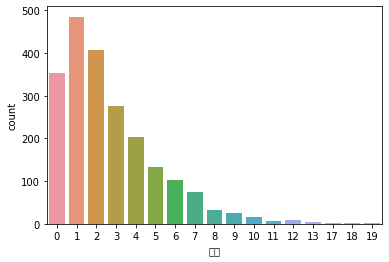

In [ ]:
x=sungwoo_df['긍정']
sns.countplot(x)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0, flags=flags)


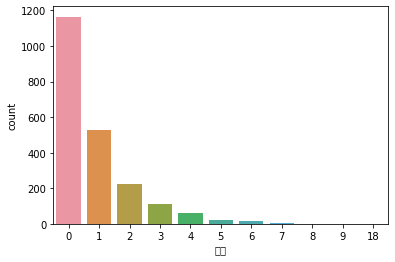

In [ ]:
x=sungwoo_df['부정']
sns.countplot(x)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44048 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44048 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0, flags=flags)


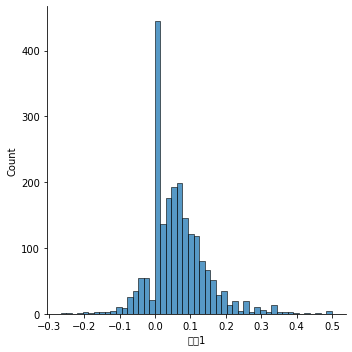

In [ ]:
x=sungwoo_df['감분1']
sns.displot(x)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44048 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44048 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48516 missing from current font.
  font.set_text(s, 0, flags=flags)


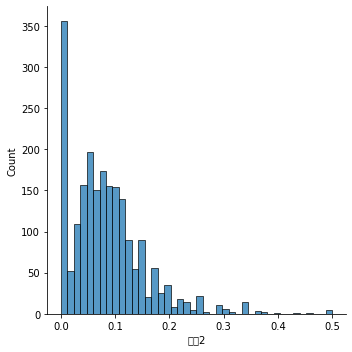

In [ ]:
x=sungwoo_df['감분2']
sns.displot(x)
plt.show()

### 애니별 점수 계산

In [ ]:
result = pd.read_csv('주인공감성분석결과.csv')
review = pd.read_csv('주인공 관련 리뷰.csv')

real_result = pd.concat([result,review],axis=1).loc[:,['title','감분1','감분2']]

In [ ]:
final = real_result.groupby('title').median()
final.sort_values(by=final.columns[0],ascending=False)

,감분1,감분2
title,,
극장판 19기 포켓몬스터 XY: 볼케니온: 기계왕국의 비밀,0.266667,0.266667
(더빙) 소닉 X,0.250000,0.250000
식극의 소마 세 번째 접시,0.208333,0.208333
킹 오브 프리즘 : 올 스타즈 프리즘 쇼☆베스트 10,0.200000,0.200000
썬더 일레븐 GO 크로노스톤,0.193548,0.193548
...,...,...
극장판 3기 포켓몬스터: 결정탑의 제왕 앤테이,-0.100000,0.000000
Fate Grand Carnival,-0.100000,0.000000
추억의 마니,-0.103448,0.000000


In [ ]:
final.to_csv('애니별주인공점수.csv')